# STATS 6289 Statistical Deep Learning 
# Howework 4 : GAN
#### Muzhe Guo
#### Oct 30, 2020


### Code Link:


In [17]:
# terminal:
#$ git clone https://github.com/eriklindernoren/PyTorch-GAN
#$ cd PyTorch-GAN/
#$ sudo python3 -m pip install -r requirements.txt

In [10]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

#plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


### Step 1: Set up parameters


In [40]:
os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=1000, help="interval betwen image samples")
opt = parser.parse_known_args()[0]
print(opt)
img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False

Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, clip_value=0.01, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_critic=5, n_epochs=50, sample_interval=1000)


### Step 2: Generator Model and Discriminator Model

In [41]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


In [42]:
k = 2
p = 6

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


### Step 3: Define plot function


In [49]:
def show_images(images):
    images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 


### Step 4:  Training and Visualization

iteration: 0, D: -0.03219, G:-0.07318


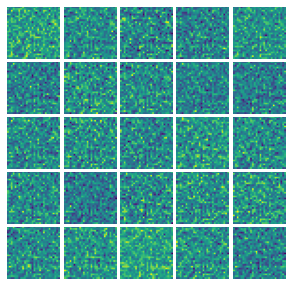

iteration: 1000, D: -3.055, G:-2.05


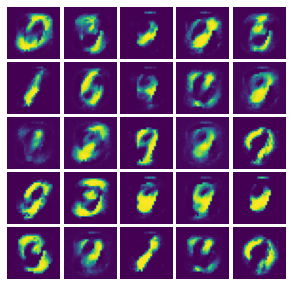

iteration: 2000, D: -3.738, G:1.421


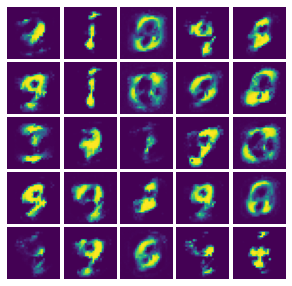

iteration: 3000, D: -3.086, G:1.364


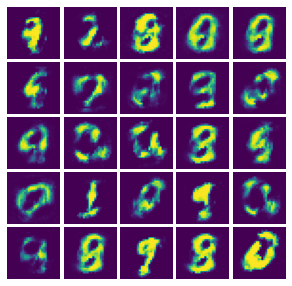

iteration: 4000, D: -2.882, G:0.2834


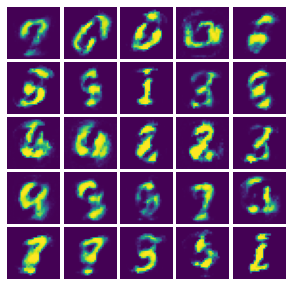

iteration: 5000, D: -2.438, G:1.031


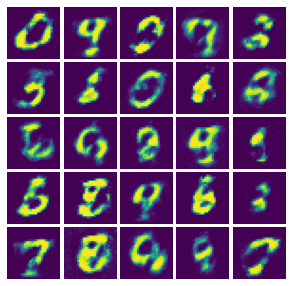

iteration: 6000, D: -2.625, G:0.9722


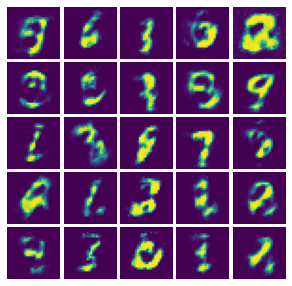

iteration: 7000, D: -2.477, G:0.3025


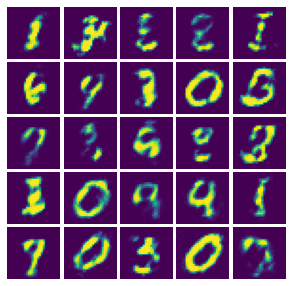

iteration: 8000, D: -2.48, G:0.241


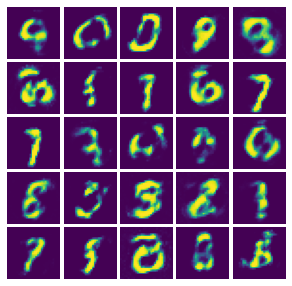

iteration: 9000, D: -2.331, G:-0.8519


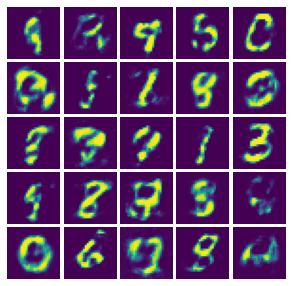

iteration: 10000, D: -2.135, G:-0.394


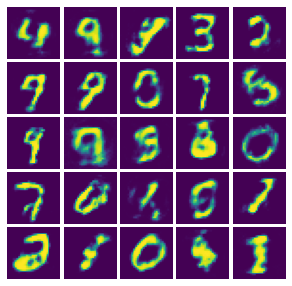

iteration: 11000, D: -1.704, G:-0.4593


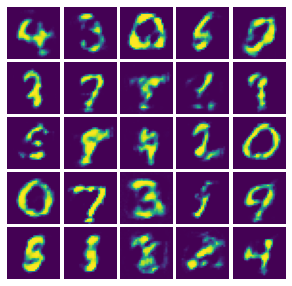

iteration: 12000, D: -1.789, G:-0.5583


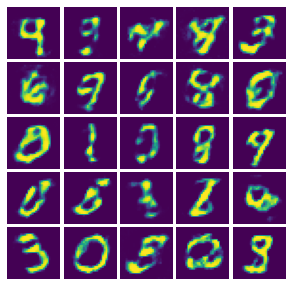

iteration: 13000, D: -1.681, G:-0.6032


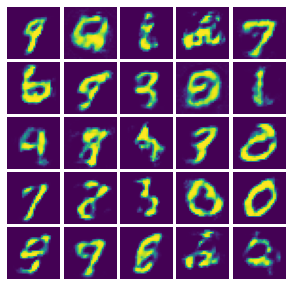

iteration: 14000, D: -1.507, G:-0.9192


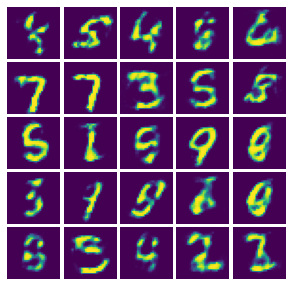

iteration: 15000, D: -1.625, G:-0.09274


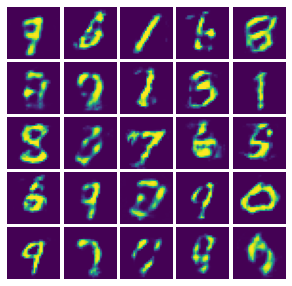

iteration: 16000, D: -1.332, G:-0.9792


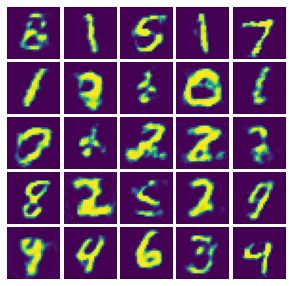

iteration: 17000, D: -1.529, G:-0.9158


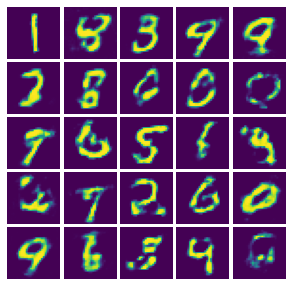

iteration: 18000, D: -1.478, G:-0.928


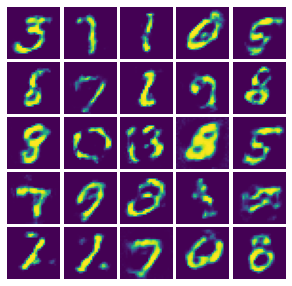

iteration: 19000, D: -1.222, G:-0.6467


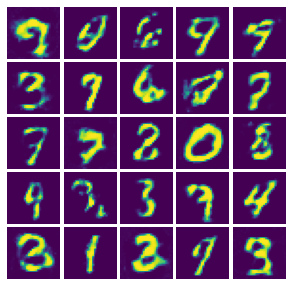

iteration: 20000, D: -1.071, G:-1.138


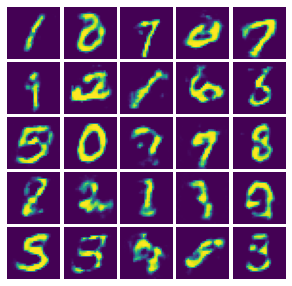

iteration: 21000, D: -0.9364, G:-0.9191


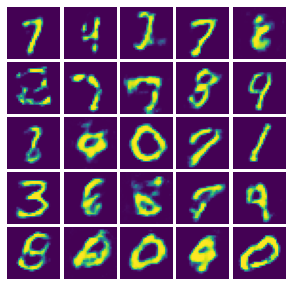

iteration: 22000, D: -1.07, G:-1.002


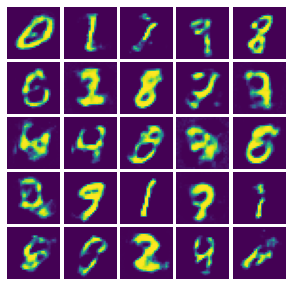

iteration: 23000, D: -1.12, G:-1.016


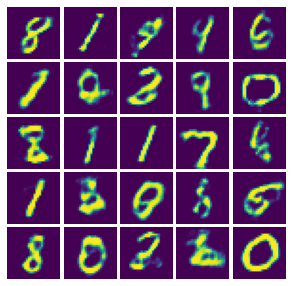

iteration: 24000, D: -1.226, G:-0.8238


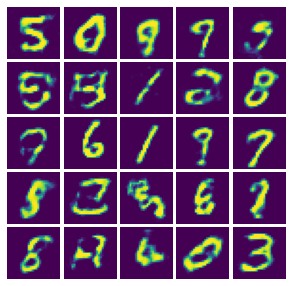

iteration: 25000, D: -0.9433, G:-1.191


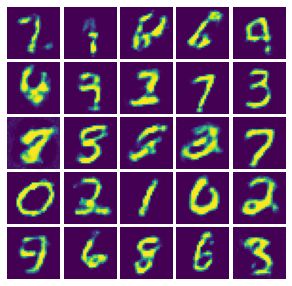

iteration: 26000, D: -0.914, G:-1.154


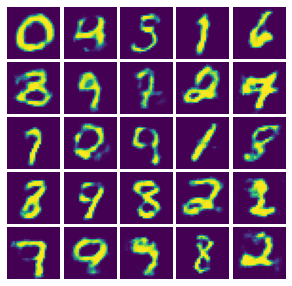

iteration: 27000, D: -0.9902, G:-1.509


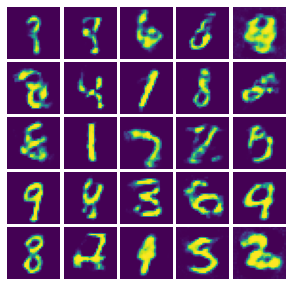

iteration: 28000, D: -1.178, G:-1.622


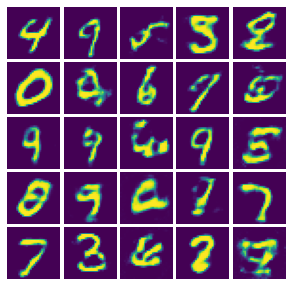

iteration: 29000, D: -1.057, G:-0.6299


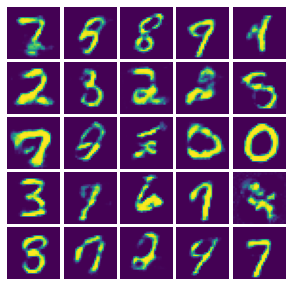

iteration: 30000, D: -1.029, G:-1.075


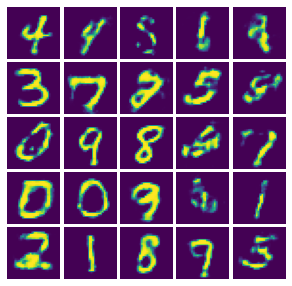

iteration: 31000, D: -0.7634, G:-1.225


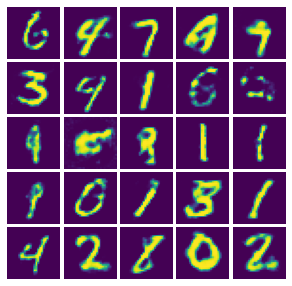

iteration: 32000, D: -1.099, G:-1.145


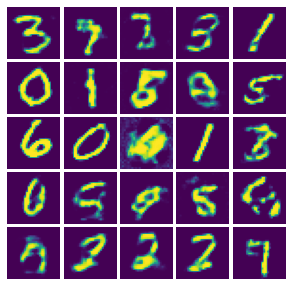

iteration: 33000, D: -1.141, G:-1.444


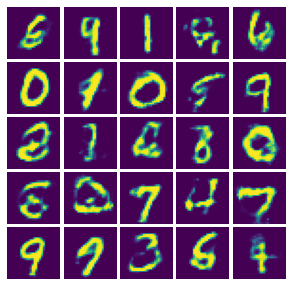

iteration: 34000, D: -0.9354, G:-1.336


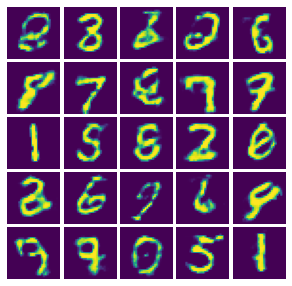

iteration: 35000, D: -0.7828, G:-1.036


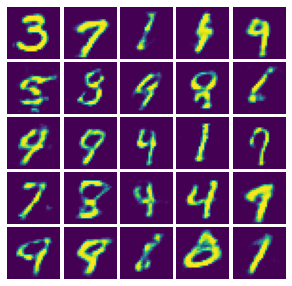

iteration: 36000, D: -1.203, G:-1.289


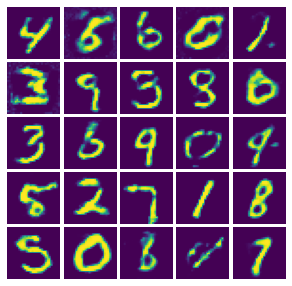

iteration: 37000, D: -0.9381, G:-1.262


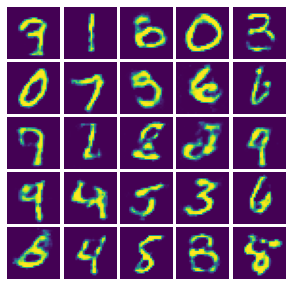

iteration: 38000, D: -0.8267, G:-1.073


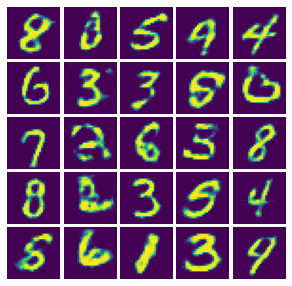

iteration: 39000, D: -0.7273, G:-1.47


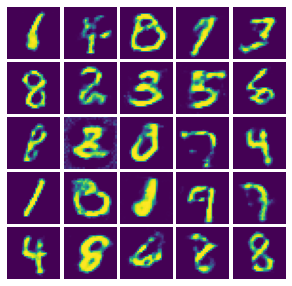

iteration: 40000, D: -0.7195, G:-1.642


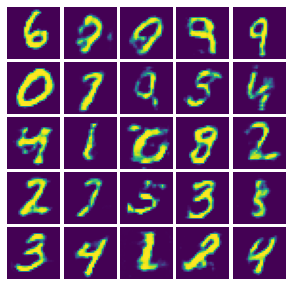

iteration: 41000, D: -0.6575, G:-1.494


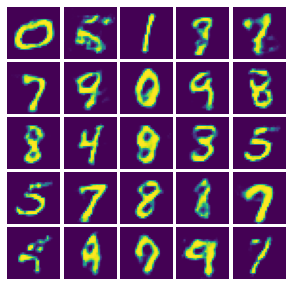

iteration: 42000, D: -0.8286, G:-1.143


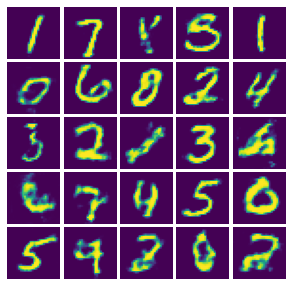

iteration: 43000, D: -0.7934, G:-1.163


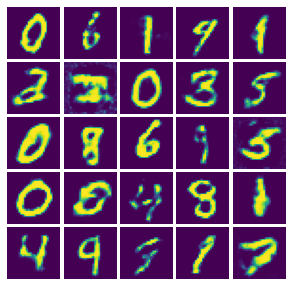

iteration: 44000, D: -0.4707, G:-0.8951


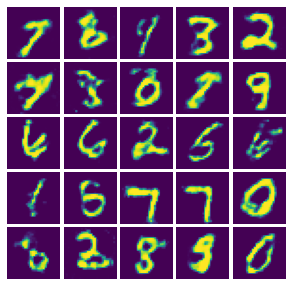

iteration: 45000, D: -0.8484, G:-1.122


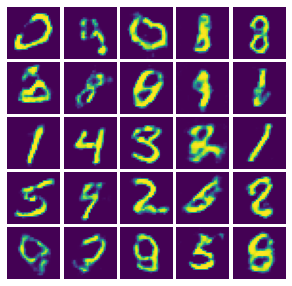

iteration: 46000, D: -0.7865, G:-0.9352


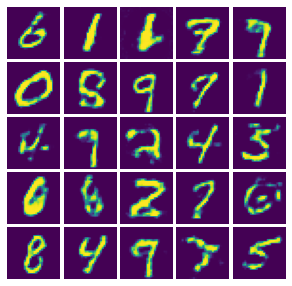

In [44]:
batches_done = 0
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True)[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True)[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            #print(
            #    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            #    % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            #)

            if batches_done % opt.sample_interval == 0:
                print('iteration: {}, D: {:.4}, G:{:.4}'.format(batches_done, d_loss.item(),g_loss.item()))
                imgs = fake_imgs.data[:25].cpu()
                show_images(imgs)
                plt.show()

                #save_image(fake_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
            batches_done += opt.n_critic 




### Final Result

Final Result  epoch: 49, D: -0.4755, G:-0.7696


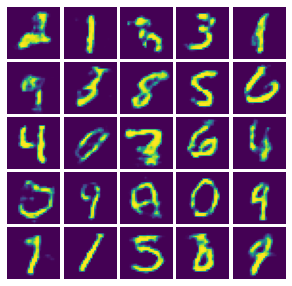

In [50]:
print('Final Result  epoch: {}, D: {:.4}, G:{:.4}'.format(epoch, d_loss.item(),g_loss.item()))
imgs = fake_imgs.data[:25].cpu()
show_images(imgs)
plt.show()